# Bootstrap Convergence

---

This is a convergence study of the `eval_bootstrap` utility. The purpose of this document is twofold:

1. Demonstrate correctness of the `eval_bootstrap` utility; this is an exercise far too expensive to include in automated unit testing.
2. Set reasonable default values for `eval_bootstrap`, particularly `con, n_boot, n_sub`.

In [26]:
import grama as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from statsmodels.stats.proportion import proportion_confint

Here we set up a very simple reference problem; estimating the true mean with the sample mean. We define `tran_mean` as the sample mean, which we will pass to `tran_bootstrap`. 

In [1]:
## Setup
np.random.seed(101)

# Script settings
mu_true = 0
CON = 0.90

df = pd.DataFrame(
    data=dict(
        X=np.random.normal(size=100, loc=mu_true)
    )
)

## Helper functions
def tran_mean(df):
    return pd.DataFrame(dict(
        mu=[np.mean(df.X)]
    ))

def do_boot(n_boot, n_sub, seed=101):
    return gr.tran_bootstrap(
        df,
        tran=tran_mean,
        n_boot=n_boot,
        n_sub=n_sub,
        seed=seed,
        con=CON
    )

def is_cov(df_res):
    return ((df_res.mu_lo < mu_true) & (mu_true < df_res.mu_up))[0]

### Generate Data

The following is the main loop, where we select sample sizes for `tran_bootstrap` to test, perform many replications, 

In [2]:
# Loop settings
N_BOOT_ALL = [100, 500, 1000]
N_SUB_ALL = [10, 25, 50]
N_REPL = 100

# Reserve space
BOOL_ALL = np.zeros((len(N_BOOT_ALL), len(N_SUB_ALL), N_REPL))
LO_ALL   = np.zeros((len(N_BOOT_ALL), len(N_SUB_ALL), N_REPL))
UP_ALL   = np.zeros((len(N_BOOT_ALL), len(N_SUB_ALL), N_REPL))

t0 = time.time()
for ind, n_boot in enumerate(N_BOOT_ALL):
    for jnd, n_sub in enumerate(N_SUB_ALL):
        for knd in range(N_REPL):
            df_tmp = do_boot(n_boot, n_sub, seed=101 + knd)
            LO_ALL[ind, jnd, knd] = df_tmp.mu_lo[0]
            UP_ALL[ind, jnd, knd] = df_tmp.mu_up[0]
            BOOL_ALL[ind, jnd, knd] = is_cov(df_tmp)
t1 = time.time()

print("Execution time: {} sec".format(t1 - t0))

Execution time: 14593.471640825272 sec


### Post-process

In [24]:
df_raw = pd.DataFrame(
    data=np.mean(BOOL_ALL, axis=2),
    columns=N_SUB_ALL
)
df_raw["Nb"] = N_BOOT_ALL
df_results = gr.tran_gather(df=df_raw, key="Ns", value="coverage", cols=N_SUB_ALL)
df_results = df_results.astype({'Ns': 'int32'})

## Compute binomial confidence intervals
res = proportion_confint(
    (df_results["coverage"].values * N_REPL),
    N_REPL
)
lo, up = res
df_results["lo"] = lo
df_results["up"] = up

df_results


,Nb,Ns,coverage,lo,up
0,100,10,0.77,0.687518,0.852482
1,500,10,0.96,0.921593,0.998407
2,1000,10,1.00,1.000000,1.000000
3,100,25,0.59,0.493602,0.686398
4,500,25,0.87,0.804086,0.935914
5,1000,25,0.91,0.853909,0.966091
6,100,50,0.61,0.514403,0.705597
7,500,50,0.66,0.567155,0.752845
8,1000,50,0.80,0.721601,0.878399


### Plot and analyze

[Text(0, 0.5, 'Empirical Coverage'), Text(0.5, 0, 'N bootstrap')]

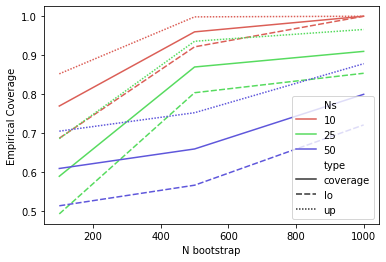

In [27]:
palette=sns.color_palette("hls", 3)
ax = sns.lineplot(
    data=gr.tran_gather(df=df_results, key="type", value="val", cols=["coverage", "lo", "up"]),
    x="Nb",
    y="val",
    hue="Ns",
    style="type",
    palette=palette
)
ax.set(xlabel='N bootstrap', ylabel='Empirical Coverage')

Observations:

- At `n_sub = 10` coverage does not converge to our desired `0.9`, but instead approaches `1.0`. This inner-loop sample size is too small to be stable.
- At `n_sub = 25` the coverage becomes compatible with the desired `0.9` by `n_boot = 500`.
- At `n_sub = 50` the convergence in `n_boot` is slower. I'm not sure why this is, but perhaps there's some error cancellation occuring---if the inner-loop estimated standard errors are more stable, the resulting CI will be more narrow, so a sharper outer loop is necessary to get the bootstrap tables right.

I will set the default values of `tran_bootstrap` to `con=0.90, n_boot = 500, n_sub = 25`, based on these results.
